Train
=====

In [36]:
%run 'ultrasound_utils.ipynb'

In [1]:
from IPython.display import display, HTML

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, roc_curve, auc
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Make sure plots are shown inside the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

In [98]:
raw_train_data = get_cleaned_ultrasound_dataset().query('GAGEDAYS < 175')

In [5]:
raw_train_data.head()

,STUDYID,SUBJID,SEXN,SEX,GAGEBRTH,BIRTHWT,BIRTHLEN,BIRTHHC,DELIVERY,PARITY,...,FEMURCM,ACAZ,BPDAZ,FLAZ,BHC_Z,BLEN_Z,BWT_Z,BWT_40,BLEN_40,BHC_40
0,1,1002,2,Female,276,3540,50.3,NaN,Category 2.0,1.0,...,7.3,0.463035,-0.237645,2.142646,NaN,0.891600,0.860470,3.614882,50.610029,NaN
3,1,1003,1,Male,280,3100,50.3,NaN,Category 2.0,1.0,...,6.3,-1.223773,-0.453516,1.616571,NaN,0.235298,-0.725564,3.100000,50.300000,NaN
4,1,1003,1,Male,280,3100,50.3,NaN,Category 2.0,1.0,...,6.3,-1.319698,-0.553987,1.495569,NaN,0.235298,-0.725564,3.100000,50.300000,NaN
5,1,1003,1,Male,280,3100,50.3,NaN,Category 2.0,1.0,...,7.2,-1.357285,-0.607140,1.106900,NaN,0.235298,-0.725564,3.100000,50.300000,NaN
6,1,1003,1,Male,280,3100,50.3,NaN,Category 2.0,1.0,...,7.2,-1.522721,-0.715238,0.876728,NaN,0.235298,-0.725564,3.100000,50.300000,NaN


In [6]:
def feature_selection1(raw_train_data):
  clean_data = raw_train_data[["SEXN", "GAGEDAYS", "HCIRCM", "ABCIRCM", "FEMURCM", "BPDCM", "ABCIRCM", "GAGEBRTH", "BWT_40"]]
  clean_data = clean_data.dropna()
  clean_labels = clean_data["BWT_40"]
  clean_data = clean_data.drop("BWT_40", 1)
  return clean_data, clean_labels

temp_data, temp_labels = feature_selection1(raw_train_data)
temp_data.join(temp_labels).describe()

,SEXN,GAGEDAYS,HCIRCM,ABCIRCM,FEMURCM,BPDCM,ABCIRCM,GAGEBRTH,BWT_40
count,7928.000000,7928.000000,7928.000000,7928.000000,7928.000000,7928.000000,7928.000000,7928.000000,7928.000000
mean,1.476917,211.135595,26.197389,24.439871,5.445194,7.303052,24.439871,274.476287,3.261737
std,0.499498,50.270776,6.604140,7.451865,1.638649,1.887381,7.451865,7.913334,0.361696
min,1.000000,31.000000,1.100000,0.400000,0.200000,1.300000,0.400000,231.000000,2.206470
25%,1.000000,172.000000,22.200000,19.100000,4.400000,6.000000,19.100000,270.000000,3.011377
50%,1.000000,224.000000,28.700000,26.500000,6.000000,8.000000,26.500000,274.000000,3.240601
75%,2.000000,256.000000,31.100000,30.425000,6.700000,8.700000,30.425000,280.000000,3.487228
max,2.000000,290.000000,36.300000,38.200000,7.900000,10.300000,38.200000,294.000000,5.713087


In [7]:
def normalized_column(col):
  return (col - col.min()) / (col.max() - col.min())

def feature_selection2(raw_train_data):
  clean_data = raw_train_data[["SEXN", "GAGEDAYS", "HCIRCM", "ABCIRCM", "FEMURCM", "BPDCM", "ABCIRCM", "BWT_40", "GAGEBRTH"]]
  clean_data = clean_data.dropna()
  clean_data["SEXN"] = normalized_column(clean_data["SEXN"])
  clean_data["GAGEDAYS"] = normalized_column(clean_data["GAGEDAYS"])
  clean_data["HCIRCM"] = normalized_column(clean_data["HCIRCM"])
  clean_data["ABCIRCM"] = normalized_column(clean_data["ABCIRCM"])
  clean_data["FEMURCM"] = normalized_column(clean_data["FEMURCM"])
  clean_data["BPDCM"] = normalized_column(clean_data["BPDCM"])
  clean_labels = clean_data["BWT_40"]
  clean_data = clean_data.drop("BWT_40", 1)
  return clean_data, clean_labels

temp_data, temp_labels = feature_selection2(raw_train_data)
temp_data.join(temp_labels).describe()

,SEXN,GAGEDAYS,HCIRCM,ABCIRCM,FEMURCM,BPDCM,ABCIRCM,GAGEBRTH,BWT_40
count,7928.000000,7928.000000,7928.000000,7928.000000,7928.000000,7928.000000,7928.000000,7928.000000,7928.000000
mean,0.476917,0.695504,0.712994,0.635975,0.681194,0.667006,0.635975,274.476287,3.261737
std,0.499498,0.194096,0.187618,0.197139,0.212812,0.209709,0.197139,7.913334,0.361696
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,231.000000,2.206470
25%,0.000000,0.544402,0.599432,0.494709,0.545455,0.522222,0.494709,270.000000,3.011377
50%,0.000000,0.745174,0.784091,0.690476,0.753247,0.744444,0.690476,274.000000,3.240601
75%,1.000000,0.868726,0.852273,0.794312,0.844156,0.822222,0.794312,280.000000,3.487228
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,294.000000,5.713087


In [8]:
def feature_selection3(raw_train_data):
  clean_data = raw_train_data[["SEXN", "GAGEDAYS", "HCIRCM", "ABCIRCM", "FEMURCM", "BPDCM", "BWT_40", "HCAZ", "ACAZ", "BPDAZ", "FLAZ"]]
  clean_data = clean_data.dropna()
  clean_data["SEXN"] = normalized_column(clean_data["SEXN"])
  clean_data["GAGEDAYS"] = normalized_column(clean_data["GAGEDAYS"])
  clean_data["HCIRCM"] = normalized_column(clean_data["HCIRCM"])
  clean_data["ABCIRCM"] = normalized_column(clean_data["ABCIRCM"])
  clean_data["FEMURCM"] = normalized_column(clean_data["FEMURCM"])
  clean_data["BPDCM"] = normalized_column(clean_data["BPDCM"])
  clean_labels = clean_data["BWT_40"]
  clean_data = clean_data.drop("BWT_40", 1)
  return clean_data, clean_labels

temp_data, temp_labels = feature_selection3(raw_train_data)
temp_data.join(temp_labels).describe()

,SEXN,GAGEDAYS,HCIRCM,ABCIRCM,FEMURCM,BPDCM,HCAZ,ACAZ,BPDAZ,FLAZ,BWT_40
count,7817.000000,7817.000000,7817.000000,7817.000000,7817.000000,7817.000000,7817.000000,7817.000000,7817.000000,7817.000000,7817.000000
mean,0.476014,0.626793,0.682074,0.613808,0.685882,0.671934,-0.688641,-0.789044,-1.109042,0.190649,3.262316
std,0.499456,0.231782,0.201220,0.203863,0.203694,0.200545,1.009758,1.188134,1.089193,1.032031,0.361548
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.702422,-9.089636,-6.474786,-5.466641,2.206470
25%,0.000000,0.441748,0.553398,0.461318,0.552632,0.539326,-1.348210,-1.348693,-1.767107,-0.504378,3.011993
50%,0.000000,0.679612,0.757282,0.667622,0.750000,0.741573,-0.711708,-0.709055,-1.084623,0.190443,3.241126
75%,1.000000,0.834951,0.831715,0.779370,0.842105,0.820225,-0.037122,-0.066534,-0.377814,0.863643,3.487228
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.626893,4.576060,2.918980,5.984496,5.713087


In [117]:
def feature_selection4(raw_train_data):
  # input colums
  measurement_columns = ["HCIRCM", "ABCIRCM", "FEMURCM", "BPDCM"]
  other_columns = ["SEXN", "PARITY", "GRAVIDA"]
  time_column = "GAGEDAYS"
  identifier_column = "SUBJID"
  output_column = "BWT_40"

  # derived columns
  time_diff_column = time_column + '_DIFF_1'
  rate_suffix = "_RATE_1"
  rate_columns = [c + rate_suffix for c in measurement_columns]
  columns_to_be_normalized = other_columns + measurement_columns + rate_columns + [time_column, time_diff_column]
  df = raw_train_data[other_columns + [time_column] + measurement_columns + [output_column] + [identifier_column]]
  df = df.dropna()

  def compute_rate(values, period):
    return (values / values.shift(1) / period).replace([np.inf, -np.inf], np.nan).fillna(0)

  def add_previous_values(grouped_rows):
    period = (grouped_rows[time_column] - grouped_rows[time_column].shift(1))
    grouped_rows[time_diff_column] = period.fillna(0)
    for c in measurement_columns:
      grouped_rows[c + rate_suffix] = compute_rate(grouped_rows[c], period)
    return grouped_rows

  def add_mutations(df, columns, suffix, f):
    for c in columns:
      df[c + suffix] = f(df[c])

  def pow_n(n):
    def f(x):
      return pow(x, n)
    return f

  def mul_x(x):
    def f(y):
      return x*y
    return f

  def div_x(x):
    def f(y):
      return y/x
    return f

  df = df.sort_values([identifier_column, time_column])
  df = df.groupby(identifier_column).apply(add_previous_values)
  for c in columns_to_be_normalized:
    df[c] = normalized_column(df[c])
  add_mutations(df, [time_column], '_p2', pow_n(2))
  add_mutations(df, [time_column], '_p3', pow_n(3))
  df = df.query(time_column + ' > 0')
  add_mutations(df, measurement_columns, '_x_time', div_x(df[time_column]))
  for c in measurement_columns:
    mut_columns = [c2 for c2 in measurement_columns if c2 != c]
    suffix = '_x_' + c
    target_columns = [c2 + suffix for c2 in mut_columns]
    add_mutations(df, mut_columns, suffix, mul_x(df[c]))
    add_mutations(df, target_columns, '_x_time', div_x(df[time_column]))

  y = df[output_column]
  df = df.drop(output_column, 1)
  df = df.drop(identifier_column, 1)
  return df, y

temp_data, temp_labels = feature_selection4(raw_train_data)
display_full(temp_data.head())
display(temp_data.join(temp_labels).corr()['BWT_40'].sort_values())
display_full(temp_data.join(temp_labels).describe())

/home/deuser/.py-virtualenvs/tf/lib/python2.7/site-packages/ipykernel/__main__.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,SEXN,PARITY,GRAVIDA,GAGEDAYS,HCIRCM,ABCIRCM,FEMURCM,BPDCM,GAGEDAYS_DIFF_1,HCIRCM_RATE_1,ABCIRCM_RATE_1,FEMURCM_RATE_1,BPDCM_RATE_1,GAGEDAYS_p2,GAGEDAYS_p3,HCIRCM_x_time,ABCIRCM_x_time,FEMURCM_x_time,BPDCM_x_time,ABCIRCM_x_HCIRCM,FEMURCM_x_HCIRCM,BPDCM_x_HCIRCM,ABCIRCM_x_HCIRCM_x_time,FEMURCM_x_HCIRCM_x_time,BPDCM_x_HCIRCM_x_time,HCIRCM_x_ABCIRCM,FEMURCM_x_ABCIRCM,BPDCM_x_ABCIRCM,HCIRCM_x_ABCIRCM_x_time,FEMURCM_x_ABCIRCM_x_time,BPDCM_x_ABCIRCM_x_time,HCIRCM_x_FEMURCM,ABCIRCM_x_FEMURCM,BPDCM_x_FEMURCM,HCIRCM_x_FEMURCM_x_time,ABCIRCM_x_FEMURCM_x_time,BPDCM_x_FEMURCM_x_time,HCIRCM_x_BPDCM,ABCIRCM_x_BPDCM,FEMURCM_x_BPDCM,HCIRCM_x_BPDCM_x_time,ABCIRCM_x_BPDCM_x_time,FEMURCM_x_BPDCM_x_time
12,0.0,0.142857,0.00,0.965035,0.896552,0.871429,0.829787,0.884615,0.00000,0.0,0.0,0.0,0.0,0.931292,0.898730,0.929035,0.903002,0.859852,0.916667,0.781281,0.743947,0.793103,0.809588,0.770902,0.821839,0.781281,0.723100,0.770879,0.809588,0.749300,0.798810,0.743947,0.723100,0.734043,0.770902,0.749300,0.760638,0.793103,0.770879,0.734043,0.821839,0.798810,0.760638
27,1.0,0.142857,0.00,0.958042,0.831897,0.890476,0.808511,0.807692,0.00000,0.0,0.0,0.0,0.0,0.917844,0.879333,0.868330,0.929475,0.843920,0.843066,0.740784,0.672597,0.671916,0.773227,0.702054,0.701343,0.740784,0.719959,0.719231,0.773227,0.751491,0.750730,0.672597,0.719959,0.653028,0.702054,0.751491,0.681628,0.671916,0.719231,0.653028,0.701343,0.750730,0.681628
32,1.0,0.142857,0.00,0.958042,0.870690,0.866667,0.872340,0.807692,0.00000,0.0,0.0,0.0,0.0,0.917844,0.879333,0.908822,0.904623,0.910545,0.843066,0.754598,0.759538,0.703249,0.787646,0.792802,0.734049,0.754598,0.756028,0.700000,0.787646,0.789139,0.730657,0.759538,0.756028,0.704583,0.792802,0.789139,0.735440,0.703249,0.700000,0.704583,0.734049,0.730657,0.735440
33,1.0,0.142857,0.00,0.965035,0.870690,0.866667,0.872340,0.807692,0.00885,1.0,1.0,1.0,1.0,0.931292,0.898730,0.902236,0.898068,0.903947,0.836957,0.754598,0.759538,0.703249,0.781938,0.787057,0.728729,0.754598,0.756028,0.700000,0.781938,0.783421,0.725362,0.759538,0.756028,0.704583,0.787057,0.783421,0.730111,0.703249,0.700000,0.704583,0.728729,0.725362,0.730111
56,1.0,0.285714,0.25,0.531469,0.431034,0.404762,0.340426,0.307692,0.00000,0.0,0.0,0.0,0.0,0.282459,0.150118,0.811025,0.761591,0.640538,0.578947,0.174466,0.146735,0.132626,0.328272,0.276094,0.249546,0.174466,0.137791,0.124542,0.328272,0.259265,0.234336,0.146735,0.137791,0.104746,0.276094,0.259265,0.197088,0.132626,0.124542,0.104746,0.249546,0.234336,0.197088


SEXN                       -0.191823
GAGEDAYS_DIFF_1            -0.027826
GRAVIDA                     0.020145
GAGEDAYS                    0.033026
FEMURCM_RATE_1              0.034425
ABCIRCM_RATE_1              0.035551
HCIRCM_RATE_1               0.036395
BPDCM_RATE_1                0.036615
GAGEDAYS_p2                 0.038561
PARITY                      0.040476
GAGEDAYS_p3                 0.042659
FEMURCM                     0.077287
BPDCM                       0.077667
HCIRCM                      0.082734
ABCIRCM                     0.091996
FEMURCM_x_time              0.092120
BPDCM_x_time                0.094122
HCIRCM_x_BPDCM              0.101296
BPDCM_x_HCIRCM              0.101296
HCIRCM_x_FEMURCM            0.101404
FEMURCM_x_HCIRCM            0.101404
FEMURCM_x_BPDCM             0.103077
BPDCM_x_FEMURCM             0.103077
FEMURCM_x_BPDCM_x_time      0.108124
BPDCM_x_FEMURCM_x_time      0.108124
ABCIRCM_x_FEMURCM           0.108914
FEMURCM_x_ABCIRCM           0.108914
A

,SEXN,PARITY,GRAVIDA,GAGEDAYS,HCIRCM,ABCIRCM,FEMURCM,BPDCM,GAGEDAYS_DIFF_1,HCIRCM_RATE_1,ABCIRCM_RATE_1,FEMURCM_RATE_1,BPDCM_RATE_1,GAGEDAYS_p2,GAGEDAYS_p3,HCIRCM_x_time,ABCIRCM_x_time,FEMURCM_x_time,BPDCM_x_time,ABCIRCM_x_HCIRCM,FEMURCM_x_HCIRCM,BPDCM_x_HCIRCM,ABCIRCM_x_HCIRCM_x_time,FEMURCM_x_HCIRCM_x_time,BPDCM_x_HCIRCM_x_time,HCIRCM_x_ABCIRCM,FEMURCM_x_ABCIRCM,BPDCM_x_ABCIRCM,HCIRCM_x_ABCIRCM_x_time,FEMURCM_x_ABCIRCM_x_time,BPDCM_x_ABCIRCM_x_time,HCIRCM_x_FEMURCM,ABCIRCM_x_FEMURCM,BPDCM_x_FEMURCM,HCIRCM_x_FEMURCM_x_time,ABCIRCM_x_FEMURCM_x_time,BPDCM_x_FEMURCM_x_time,HCIRCM_x_BPDCM,ABCIRCM_x_BPDCM,FEMURCM_x_BPDCM,HCIRCM_x_BPDCM_x_time,ABCIRCM_x_BPDCM_x_time,FEMURCM_x_BPDCM_x_time,BWT_40
count,2006.000000,2006.000000,2006.000000,2006.000000,2006.000000,2006.000000,2006.000000,2006.000000,2006.000000,2006.000000,2006.000000,2006.000000,2006.000000,2006.000000,2006.000000,2006.000000,2006.000000,2006.000000,2006.000000,2006.000000,2006.000000,2006.000000,2006.000000,2006.000000,2006.000000,2006.000000,2006.000000,2006.000000,2006.000000,2006.000000,2006.000000,2006.000000,2006.000000,2006.000000,2006.000000,2006.000000,2006.000000,2006.000000,2006.000000,2006.000000,2006.000000,2006.000000,2006.000000,2006.000000
mean,0.476570,0.136234,0.108487,0.767446,0.675489,0.649290,0.624467,0.632554,0.101646,0.062386,0.063872,0.068515,0.062159,0.633128,0.543096,0.868846,0.824694,0.765706,0.778955,0.488477,0.478497,0.484064,0.578710,0.559115,0.566739,0.488477,0.464232,0.469162,0.578710,0.540413,0.547085,0.478497,0.464232,0.461479,0.559115,0.540413,0.533799,0.484064,0.469162,0.461479,0.566739,0.547085,0.533799,3.254412
std,0.499575,0.096384,0.143163,0.210182,0.220266,0.229066,0.260659,0.259945,0.203488,0.190358,0.190415,0.190443,0.190353,0.275337,0.295314,0.149222,0.153162,0.218114,0.214586,0.250796,0.257316,0.260259,0.227703,0.248495,0.250391,0.250796,0.255313,0.257354,0.227703,0.248916,0.249827,0.257316,0.255313,0.260072,0.248495,0.248916,0.259838,0.260259,0.257354,0.260072,0.250391,0.249827,0.259838,0.373969
min,0.000000,0.000000,0.000000,0.125874,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015844,0.001994,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.206470
25%,0.000000,0.142857,0.000000,0.729021,0.625000,0.585714,0.574468,0.576923,0.000000,0.000000,0.000000,0.000000,0.000000,0.531481,0.387474,0.841144,0.795364,0.768023,0.767442,0.368596,0.357117,0.356764,0.500163,0.487799,0.485461,0.368596,0.336474,0.339927,0.500163,0.457980,0.462678,0.357117,0.336474,0.331424,0.487799,0.457980,0.450908,0.356764,0.339927,0.331424,0.485461,0.462678,0.450908,3.000015
50%,0.000000,0.142857,0.000000,0.811189,0.732759,0.704762,0.702128,0.711538,0.000000,0.000000,0.000000,0.000000,0.000000,0.658027,0.533784,0.884473,0.854739,0.842135,0.848131,0.515333,0.514032,0.522546,0.636117,0.629924,0.635223,0.515333,0.491489,0.501282,0.636117,0.605891,0.609795,0.514032,0.491489,0.497545,0.629924,0.605891,0.601618,0.522546,0.501282,0.497545,0.635223,0.609795,0.601618,3.223821
75%,1.000000,0.142857,0.125000,0.923077,0.840517,0.823810,0.808511,0.826923,0.024336,0.039782,0.045357,0.058114,0.038946,0.852071,0.786527,0.921620,0.900787,0.890503,0.902672,0.695941,0.690022,0.689324,0.748620,0.745518,0.742247,0.695941,0.675684,0.676923,0.748620,0.725556,0.725481,0.690022,0.675684,0.670213,0.745518,0.725556,0.724110,0.689324,0.676923,0.670213,0.742247,0.725481,0.724110,3.488135
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.499761,2.042857,1.761478,1.718750,1.000000,0.948276,0.980769,1.007117,0.963488,1.036994,1.000000,0.936778,0.990476,1.007117,0.956231,1.033855,0.948276,0.936778,0.959902,0.963488,0.956231,0.987525,0.980769,0.990476,0.959902,1

R^2 on the train set:
0.0170842053434

R^2 on the test set:
0.0907414023989
columns: ['SEXN' 'GAGEDAYS' 'HCIRCM' 'ABCIRCM' 'FEMURCM' 'BPDCM' 'ABCIRCM'
 'GAGEBRTH']


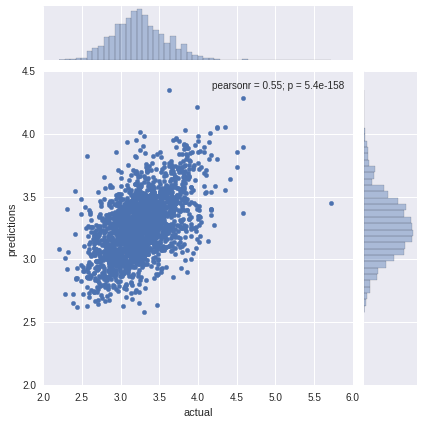

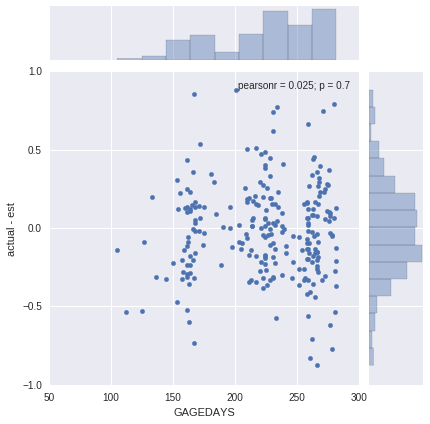

In [11]:
X, y = feature_selection1(raw_train_data)
train_and_evaluate_model(RandomForestRegressor(), X, y)


R^2 on the train set:
0.0172896853565

R^2 on the test set:
0.0923189058283
columns: ['SEXN' 'GAGEDAYS' 'HCIRCM' 'ABCIRCM' 'FEMURCM' 'BPDCM' 'ABCIRCM'
 'GAGEBRTH']


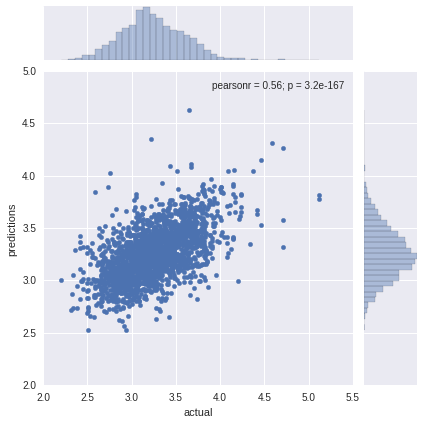

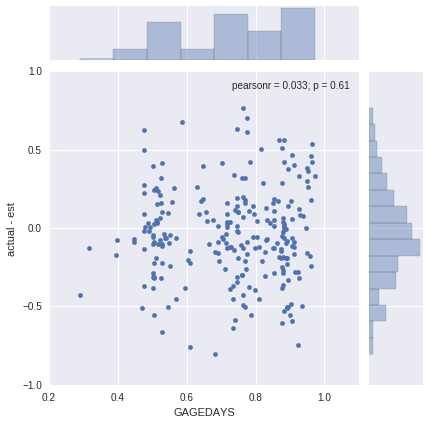

In [12]:
X, y = feature_selection2(raw_train_data)
train_and_evaluate_model(RandomForestRegressor(), X, y)

R^2 on the train set:
0.0169538530714

R^2 on the test set:
0.0942255585718
columns: ['SEXN' 'GAGEDAYS' 'HCIRCM' 'ABCIRCM' 'FEMURCM' 'BPDCM' 'HCAZ' 'ACAZ'
 'BPDAZ' 'FLAZ']


(RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False), 10421    2.827181
 213      3.644616
 14375    4.213954
 8526     3.079781
 5882     3.294206
 1562     2.940000
 8348     3.479779
 1718     3.787528
 6202     3.206165
 9897     3.507164
 4613     3.553096
 1635     2.846855
 9185     3.111142
 8603     3.159054
 8145     3.547763
 13050    3.019928
 10602    2.936603
 14963    3.945438
 16100    3.843213
 3720     3.221681
 3390     2.642821
 6861     3.715943
 8490     3.078422
 8231     3.396758
 7942     3.664560
 12888    3.079977
 10651    3.680000
 12583    3.409719
 6260     2.956547
 7113     3.245735
            ...   
 15679    3.023090
 4454     3.883944
 7017     

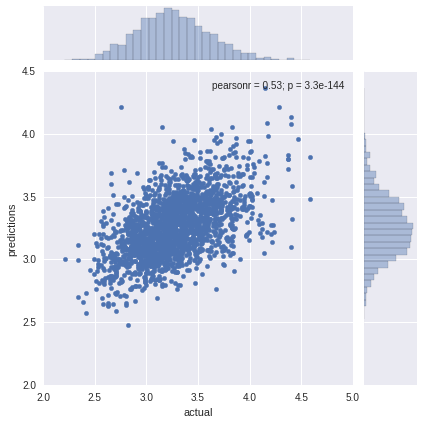

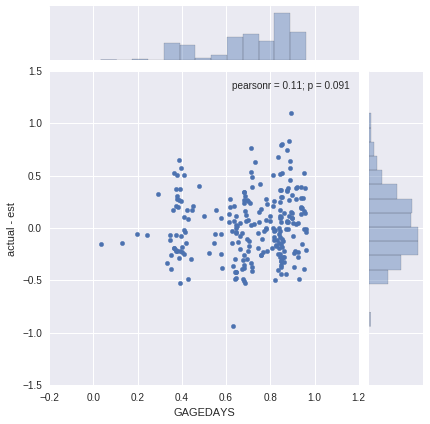

In [86]:
X, y = feature_selection3(raw_train_data)
train_and_evaluate_model(RandomForestRegressor(), X, y)

In [114]:
X, y = feature_selection4(raw_train_data)

/home/deuser/.py-virtualenvs/tf/lib/python2.7/site-packages/ipykernel/__main__.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


R^2 on the train set:
0.0233817488396

R^2 on the test set:
0.145624950968
columns: ['SEXN' 'PARITY' 'GRAVIDA' 'GAGEDAYS' 'HCIRCM' 'ABCIRCM' 'FEMURCM' 'BPDCM'
 'GAGEDAYS_DIFF_1' 'HCIRCM_RATE_1' 'ABCIRCM_RATE_1' 'FEMURCM_RATE_1'
 'BPDCM_RATE_1' 'GAGEDAYS_p2' 'GAGEDAYS_p3' 'HCIRCM_x_time'
 'ABCIRCM_x_time' 'FEMURCM_x_time' 'BPDCM_x_time' 'ABCIRCM_x_HCIRCM'
 'FEMURCM_x_HCIRCM' 'BPDCM_x_HCIRCM' 'ABCIRCM_x_HCIRCM_x_time'
 'FEMURCM_x_HCIRCM_x_time' 'BPDCM_x_HCIRCM_x_time' 'HCIRCM_x_ABCIRCM'
 'FEMURCM_x_ABCIRCM' 'BPDCM_x_ABCIRCM' 'HCIRCM_x_ABCIRCM_x_time'
 'FEMURCM_x_ABCIRCM_x_time' 'BPDCM_x_ABCIRCM_x_time' 'HCIRCM_x_FEMURCM'
 'ABCIRCM_x_FEMURCM' 'BPDCM_x_FEMURCM' 'HCIRCM_x_FEMURCM_x_time'
 'ABCIRCM_x_FEMURCM_x_time' 'BPDCM_x_FEMURCM_x_time' 'HCIRCM_x_BPDCM'
 'ABCIRCM_x_BPDCM' 'FEMURCM_x_BPDCM' 'HCIRCM_x_BPDCM_x_time'
 'ABCIRCM_x_BPDCM_x_time' 'FEMURCM_x_BPDCM_x_time']


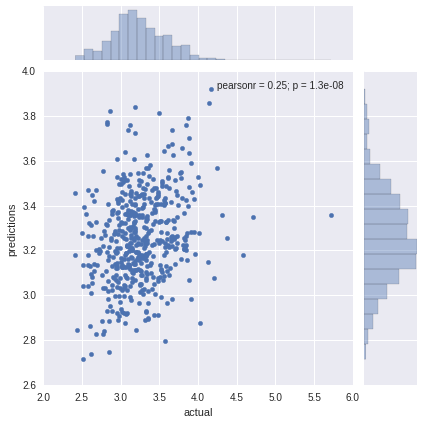

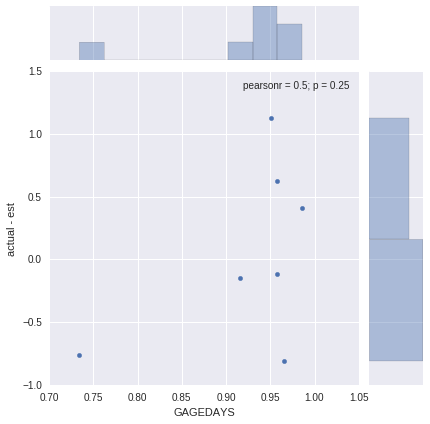

In [115]:
%run 'ultrasound_utils.ipynb'
model, Y_test, predictions = train_and_evaluate_model(RandomForestRegressor(), X, y, roc_curve=False)

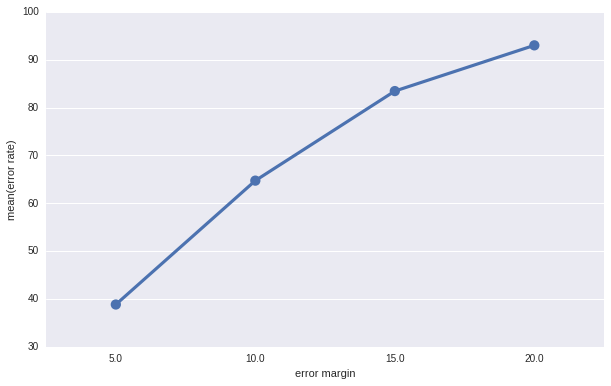

In [116]:
%run 'ultrasound_utils.ipynb'

plot_roc_curve(Y_test, predictions)

In [38]:
train_and_evaluate_model(LinearRegressor(), X, y)

NameError: name 'LinearRegressor' is not defined

In [15]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD
from keras.wrappers.scikit_learn import KerasRegressor

input_dim = 0

def build_fn_reg(hidden_dims=50):
  print "hidden_dims:", hidden_dims
  model = Sequential()
  model.add(Dense(input_dim, input_shape=(input_dim,), init='normal', activation='relu'))
  model.add(Dense(hidden_dims, init='normal', activation='relu'))
  model.add(Dense(hidden_dims, init='normal', activation='relu'))
  model.add(Dense(1, init='normal', activation='linear'))
  model.compile(optimizer='adam', loss='mean_absolute_error',
    metrics=['accuracy'])
  return model

Using TensorFlow backend.


hidden_dims: 150
R^2 on the train set:
0.143385476163

R^2 on the test set:
0.129727526322
columns: ['SEXN' 'GAGEDAYS' 'HCIRCM' 'ABCIRCM' 'FEMURCM' 'BPDCM' 'ABCIRCM'
 'GAGEBRTH']


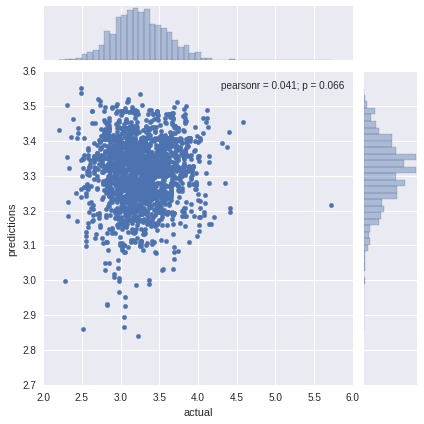

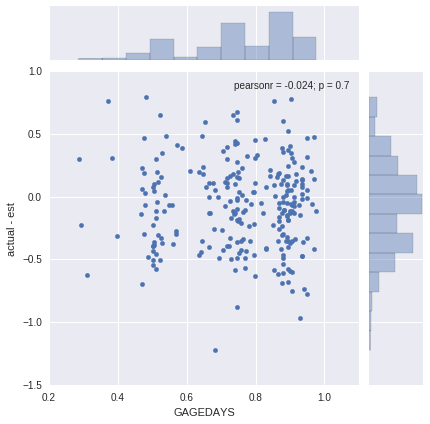

In [16]:
X, y = feature_selection2(raw_train_data)
input_dim = len(X.columns.values)
train_and_evaluate_model(KerasRegressor(
  build_fn=build_fn_reg, hidden_dims=150,
  batch_size=100, nb_epoch=10, verbose = 0), X, y)

hidden_dims: 150
R^2 on the train set:
0.090401317584

R^2 on the test set:
0.0858305566094
columns: ['SEXN' 'GAGEDAYS' 'HCIRCM' 'ABCIRCM' 'FEMURCM' 'BPDCM' 'HCAZ' 'ACAZ'
 'BPDAZ' 'FLAZ']


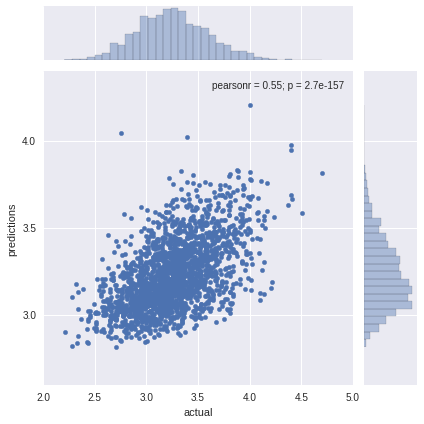

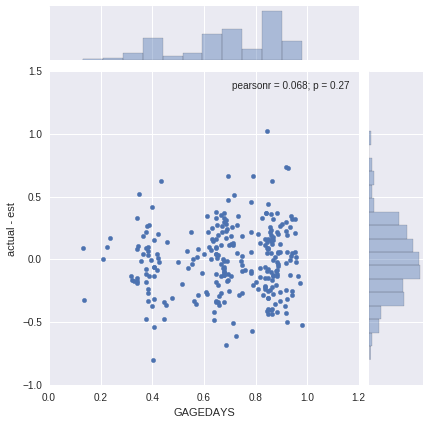

In [17]:
X, y = feature_selection3(raw_train_data)
input_dim = len(X.columns.values)
train_and_evaluate_model(KerasRegressor(
  build_fn=build_fn_reg, hidden_dims=150,
  batch_size=100, nb_epoch=10, verbose = 0), X, y)

hidden_dims: 350
R^2 on the train set:
0.116111584497

R^2 on the test set:
0.149367094231
columns: ['SEXN' 'PARITY' 'GRAVIDA' 'GAGEDAYS' 'HCIRCM' 'ABCIRCM' 'FEMURCM' 'BPDCM'
 'GAGEDAYS_DIFF_1' 'HCIRCM_RATE_1' 'ABCIRCM_RATE_1' 'FEMURCM_RATE_1'
 'BPDCM_RATE_1' 'GAGEDAYS_p2' 'GAGEDAYS_p3' 'HCIRCM_x_time'
 'ABCIRCM_x_time' 'FEMURCM_x_time' 'BPDCM_x_time' 'ABCIRCM_x_HCIRCM'
 'FEMURCM_x_HCIRCM' 'BPDCM_x_HCIRCM' 'ABCIRCM_x_HCIRCM_x_time'
 'FEMURCM_x_HCIRCM_x_time' 'BPDCM_x_HCIRCM_x_time' 'HCIRCM_x_ABCIRCM'
 'FEMURCM_x_ABCIRCM' 'BPDCM_x_ABCIRCM' 'HCIRCM_x_ABCIRCM_x_time'
 'FEMURCM_x_ABCIRCM_x_time' 'BPDCM_x_ABCIRCM_x_time' 'HCIRCM_x_FEMURCM'
 'ABCIRCM_x_FEMURCM' 'BPDCM_x_FEMURCM' 'HCIRCM_x_FEMURCM_x_time'
 'ABCIRCM_x_FEMURCM_x_time' 'BPDCM_x_FEMURCM_x_time' 'HCIRCM_x_BPDCM'
 'ABCIRCM_x_BPDCM' 'FEMURCM_x_BPDCM' 'HCIRCM_x_BPDCM_x_time'
 'ABCIRCM_x_BPDCM_x_time' 'FEMURCM_x_BPDCM_x_time']


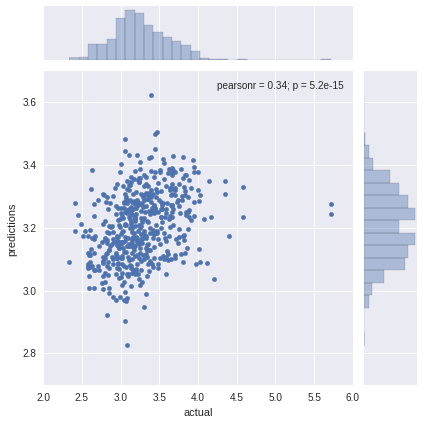

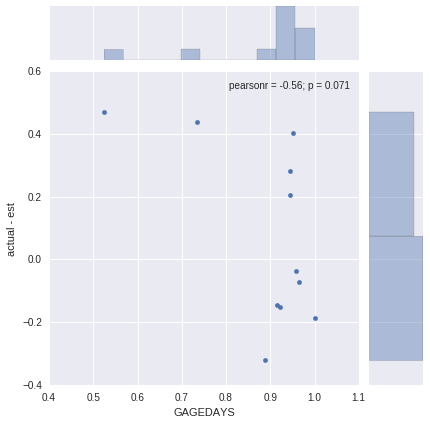

In [102]:
X, y = feature_selection4(raw_train_data)
input_dim = len(X.columns.values)
model, Y_test, predictions = train_and_evaluate_model(KerasRegressor(
  build_fn=build_fn_reg, hidden_dims=350,
  batch_size=100, nb_epoch=50, verbose = 0), X, y)

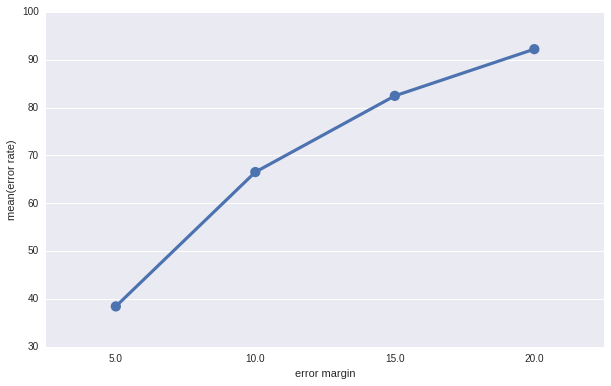

In [103]:
%run 'ultrasound_utils.ipynb'

plot_roc_curve(Y_test, predictions)